# Event Studies and Regressions
Master thesis of Nikolai Popov, MAE-2025

In [1]:
# Install required libraries
!pip install libpysal esda > /dev/null 2>&1 # hide output
!pip install linearmodels esda > /dev/null 2>&1 # hide output

In [2]:
# Libraries import
import numpy as np # for matrices/vectors
import warnings # to supress warninings
warnings.simplefilter(action='ignore', category=Warning)
from scipy.sparse import identity, kron, csr_matrix, save_npz # for memory efficient sparse matrix
import pandas as pd # dataframes
from libpysal.weights import WSP # to work with sparse inputs
import matplotlib.pyplot as plt # for plots
import statsmodels.formula.api as smf #estimate regression models using R-style formulas
import re # for regular expressions
import geopandas as gpd # to to read shape files
import statsmodels.api as sm # for spatial event-studies
import statsmodels.formula.api as smf # for spatial event-studies
from scipy.sparse import csr_matrix, identity, kron # for spatial event-studies
from scipy.sparse import load_npz # to load W_NT
from linearmodels.panel import PanelOLS # for within estimator
plt.rcParams.update({'font.size': 12}) # setting font of the plot to 14
from scipy.optimize import minimize # for non-linear methods
from matplotlib.ticker import FormatStrFormatter # for plots
from scipy.optimize import least_squares # for NLLS
from scipy.stats import norm # for normal distribution
from IPython.display import display # for regression table
from IPython.display import Javascript # for automatic actions with the collab file
from google.colab import runtime # this to work with Google drive automatically

In [3]:
# Mount Google Drive in Colab
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the path to the file in Google Drive
file_path_df = "/content/drive/My Drive/Master_Thesis/balanced_dataset_file_collab.csv"
file_path_gdf = "/content/drive/My Drive/Master_Thesis/W_NT_sparse.npz"

# Load CSV with correct encoding and delimiter
balanced_df = pd.read_csv(file_path_df, sep=",", on_bad_lines="skip", low_memory=False)

# scaling to millions of rub
balanced_df['Capital'] = balanced_df['Capital'] / 1e6
balanced_df['Output']  = balanced_df['Output']  / 1e6

loader = np.load(file_path_gdf, allow_pickle=True)
W_NT_sparse = csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                           shape=loader['shape'])

# Check that it loaded correctly:
print(f"shape of the SWM W_NT:{W_NT_sparse.shape}")

# Show first few rows
balanced_df.head()

shape of the SWM W_NT:(50952, 50952)


,INN,Year,okveds,coord,Capital,Labor,Output,Post_d,Treated_d
0,6151009768,2011,"['01.11', '01.11', '01.11', '01.13', '01.46', ...","47.803627, 39.949572",17.231,50,59.955,0,1
1,6151009768,2012,"['01.11', '01.11', '01.11', '01.13', '01.46', ...","47.803627, 39.949572",18.447,59,105.167,0,1
2,6151009768,2013,"['01.11', '01.11', '01.11', '01.13', '01.46', ...","47.803627, 39.949572",18.367,48,68.022,0,1
3,6151009768,2014,"['01.11', '01.11', '01.11', '01.13', '01.46', ...","47.803627, 39.949572",27.051,55,96.356,1,1
4,6151009768,2015,"['01.11', '01.11', '01.11', '01.13', '01.46', ...","47.803627, 39.949572",26.695,64,105.982,1,1


In [5]:
balanced_df.shape

(50952, 9)

# Event studies

## Standard DID

$$
ln(Y_{it}) = \sum_{\ell \neq -1} \beta_{\ell} \cdot \text{Treated}_i \cdot \mathbb{1}(\text{event\_time} = \ell) + ln(\text{Capital}_{it}) +  ln(\text{Labor}_{it}) + \delta_i + \delta_t + \varepsilon_{it}
$$

np.log(Output) ~ np.log(Capital) + np.log(Labor)  + Treated_d:event_t_minus3 + Treated_d:event_t_minus2 + Treated_d:event_t_0 + Treated_d:event_t_1 + Treated_d:event_t_2 + C(INN) + C(Year)


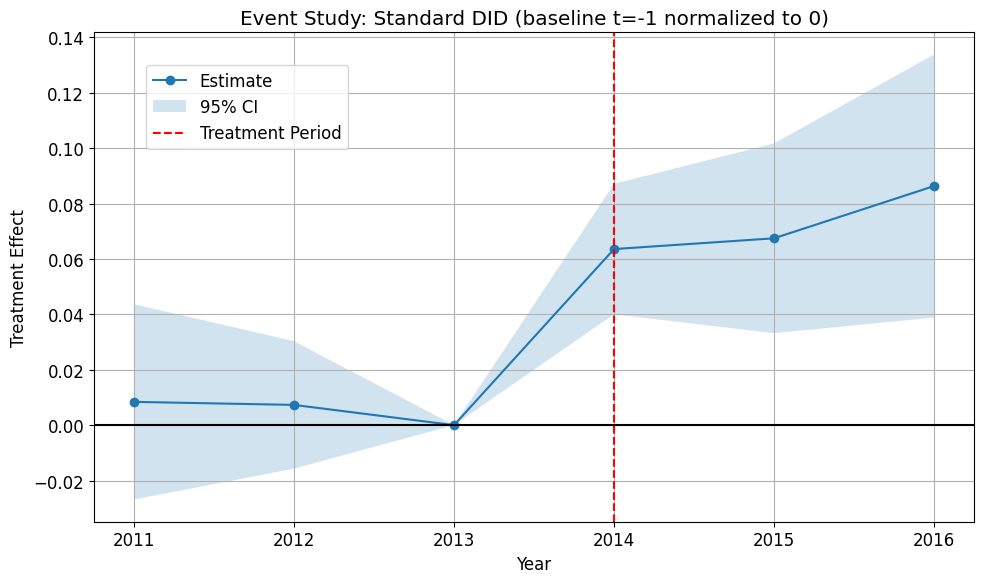

In [6]:
# --- Standard DID Event Study ---
# Step 1: Define treatment year and compute event time

treatment_year = 2014
event_df = balanced_df.copy()
event_df['event_time'] = event_df['Year'] - treatment_year

# Step 2: Create event time dummies for all periods (including baseline)
event_df = pd.get_dummies(event_df, columns=['event_time'], prefix='event', drop_first=False)

# Step 3: Rename event dummy columns to be Patsy-safe (to make R-like regression formulas)
rename_dict = {}
for col in event_df.columns:
    if re.match(r"event_-?\d+", col):
        # convert 'event_-1' to 'event_t_minus1' and 'event_2' to 'event_t_2'
        new_col = (
            col.replace("event_-", "event_t_minus")
            if col.startswith("event_-")
            else col.replace("event_", "event_t_")
        )
        rename_dict[col] = new_col

event_df = event_df.rename(columns=rename_dict)

# Step 4: Select all event dummies except the baseline (t = -1)
event_dummies = [
    c for c in event_df.columns
    if c.startswith('event_t_') and c != 'event_t_minus1'
]

# ensure Treated_d is numeric
event_df["Treated_d"] = event_df["Treated_d"].astype(int)

# ensure every event dummy is numeric
for c in event_dummies:
    event_df[c] = event_df[c].astype(int)

# Step 5: Build regression formula with interaction terms
interaction_terms = [f"Treated_d:{c}" for c in event_dummies]
formula = (
    "np.log(Output) ~ np.log(Capital) + np.log(Labor)  + " +
    " + ".join(interaction_terms) +
    " + C(INN) + C(Year)"
)

# Step 6: Estimate the model with clustered standard errors on full sample
model = smf.ols(formula=formula, data=event_df).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": event_df["INN"],   # cluster by entity
        "groups2": event_df["Year"]  # cluster by time period
    }
)

# --- Extract coefficients and standard errors for plotting ---
event_coefs = model.params[model.params.index.str.startswith("Treated_d:event_t_")]
event_ses = model.bse[model.bse.index.str.startswith("Treated_d:event_t_")]

# Parse event time from coefficient names
event_times_raw = event_coefs.index.str.extract(r"event_t_minus(\d+)|event_t_(\d+)")
minus = -event_times_raw[0].fillna(0).astype(int)
plus = event_times_raw[1].fillna(0).astype(int)
event_times = minus + plus

# Build DataFrame
plot_df = pd.DataFrame({
    'event_time': event_times.values,
    'coef': event_coefs.values,
    'se': event_ses.values
}).drop_duplicates('event_time')

# Ensure baseline (t=-1) is present
if -1 not in plot_df['event_time'].values:
    baseline = pd.DataFrame({'event_time': [-1], 'coef': [0.0], 'se': [0.0]})
    plot_df = pd.concat([plot_df, baseline], ignore_index=True)

plot_df = plot_df.sort_values('event_time')
plot_df['year'] = plot_df['event_time'] + treatment_year

# Step 7: Plot the event study
plt.figure(figsize=(10, 6))
plt.plot(plot_df['year'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(
    plot_df['year'],
    plot_df['coef'] - 1.96 * plot_df['se'],
    plot_df['coef'] + 1.96 * plot_df['se'],
    alpha=0.2, label='95% CI'
)
plt.axvline(x=treatment_year, color='red', linestyle='--', label='Treatment Period')
plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Treatment Effect')
plt.title('Event Study: Standard DID (baseline t=-1 normalized to 0)')
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Master_Thesis/event_study.png", dpi=1000, bbox_inches="tight")
print(formula)
plt.show()

## Spatial DID

$$
ln(Y_{it})
\;=\;
\sum_{\ell \neq -1}
  \delta_{\ell}\,\bigl(D_{i}\times\mathbf{1}\{\,\mathrm{event\_time}=\ell\}\bigr)
\;+\;
\sum_{\ell \neq -1}
  \gamma_{\ell}\,\bigl((W_{NT}D)_{i}\times\mathbf{1}\{\,\mathrm{event\_time}=\ell\}\bigr)
\;+\;
ln(\text{Capital}_{it}) \;+\;  ln(\text{Labor}_{it})
\;+\;
\varepsilon_{it}\,
$$

np.log(Output) ~ np.log(Capital) + np.log(Labor) + direct_event_t_minus3 + direct_event_t_minus2 + direct_event_t_0 + direct_event_t_1 + direct_event_t_2 + spatial_direct_event_t_minus3 + spatial_direct_event_t_minus2 + spatial_direct_event_t_0 + spatial_direct_event_t_1 + spatial_direct_event_t_2 + C(INN) + C(Year)


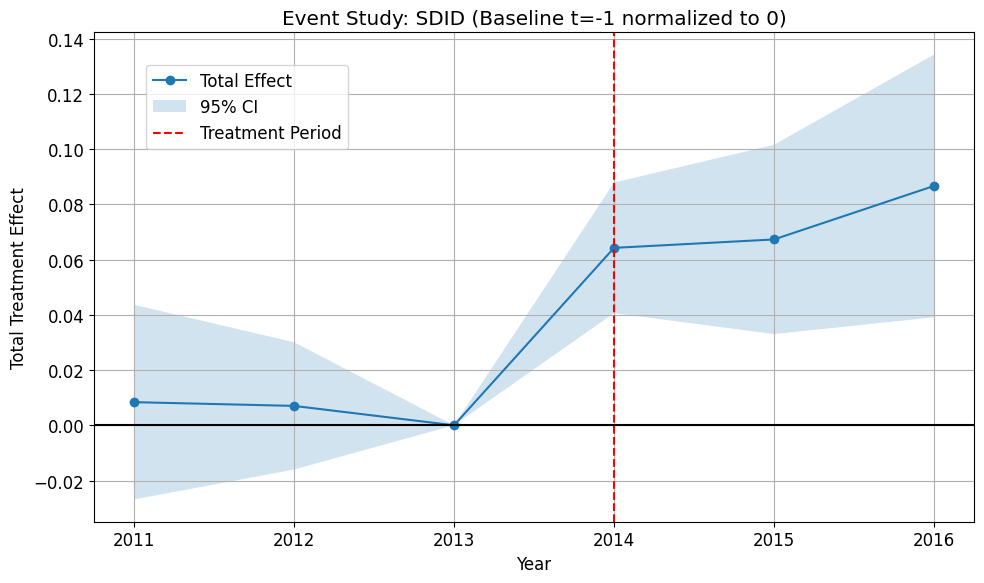

In [7]:
# --- Spatial DID Event Study ---

treatment_year = 2014

# PART 1: Data Preparation & Direct Interactions
# --------------------------------------------------
df = balanced_df.copy()
df['event_time'] = df['Year'] - treatment_year

# Create event-time dummies for all periods (including t=-1)
df = pd.get_dummies(df, columns=['event_time'], prefix='event', drop_first=False)

# Rename to Patsy-safe names
ename = {}
for col in df.columns:
    m = re.match(r"event_(-?\d+)", col)
    if m:
        t = m.group(1)
        new = f"event_t_minus{t[1:]}" if t.startswith('-') else f"event_t_{t}"
        ename[col] = new
df.rename(columns=ename, inplace=True)

# Define event dummies, excluding baseline t=-1
event_cols = [c for c in df if c.startswith('event_t_') and c != 'event_t_minus1']

# Ensure Treated_d and event dummies are numeric
if df['Treated_d'].dtype != int:
    df['Treated_d'] = df['Treated_d'].astype(int)
for c in event_cols:
    df[c] = df[c].astype(int)

# Direct interactions: D_i × I_l
direct_cols = []
for c in event_cols:
    dc = f'direct_{c}'
    df[dc] = df['Treated_d'] * df[c]
    direct_cols.append(dc)

# PART 2: Spatial interactions
# --------------------------------------------------
# Subset spatial weights to match df's rows
W_sub = W_NT_sparse[df.index, :][:, df.index]

# Compute W_sub times the matrix of direct interactions
WX = W_sub.dot(df[direct_cols].values) # .dot() performs matrix multiplication on sparse matrices
spatial_cols = []
for i, dc in enumerate(direct_cols):
    sc = f'spatial_{dc}'
    df[sc] = WX[:, i]
    spatial_cols.append(sc)

# PART 3: Regression via formula
# --------------------------------------------------
all_terms = direct_cols + spatial_cols
formula = (
    'np.log(Output) ~ np.log(Capital) + np.log(Labor) + ' +
    ' + '.join(all_terms) +
    ' + C(INN) + C(Year)'
)
model_spatial = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={
        'groups': df['INN'],    # cluster by entity
        'groups2': df['Year']   # cluster by time
    }
)
# PART 4: Extract & Assemble for Plotting with Correct SEs
# --------------------------------------------------
# Retrieve coefficient arrays
direct_mask  = model_spatial.params.index.str.startswith('direct_event_t_')
spatial_mask = model_spatial.params.index.str.startswith('spatial_direct_event_t_')
direct_coefs, direct_ses = model_spatial.params[direct_mask], model_spatial.bse[direct_mask]
spatial_coefs, spatial_ses = model_spatial.params[spatial_mask], model_spatial.bse[spatial_mask]

# Full variance-covariance matrix
vcov = model_spatial.cov_params()

# Helper to parse event time
def parse_t(name, prefix):
    core = name.replace(prefix, '').split('_')[-1]
    if core.startswith('minus'):
        return -int(core.replace('minus', ''))
    return int(core)

# Build dictionaries
direct_dict = {parse_t(n, 'direct_event_t_'): (coef, direct_ses[n])
               for n, coef in direct_coefs.items()}
spatial_dict = {parse_t(n, 'spatial_direct_event_t_'): (coef, spatial_ses[n])
                for n, coef in spatial_coefs.items()}

# Combine effects and compute correct SEs
effects = {}
for t in sorted(set(direct_dict) | set(spatial_dict)):
    dcoef, dse = direct_dict.get(t, (0.0, 0.0))
    scoef, sse = spatial_dict.get(t, (0.0, 0.0))
    # param names for covariance lookup
    dname = f'direct_event_t_{t}' if t >= 0 else f'direct_event_t_minus{abs(t)}'
    sname = f'spatial_direct_event_t_{t}' if t >= 0 else f'spatial_direct_event_t_minus{abs(t)}'
    var_d = vcov.at[dname, dname] if dname in vcov.index else 0.0
    var_s = vcov.at[sname, sname] if sname in vcov.index else 0.0
    cov_ds = vcov.at[dname, sname] if (dname in vcov.index and sname in vcov.index) else 0.0
    total_coef = dcoef + scoef
    total_se   = np.sqrt(var_d + var_s + 2*cov_ds)
    effects[t] = (total_coef, total_se)

# Build plot DataFrame
plot_df = pd.DataFrame({
    'event_time': list(effects.keys()),
    'coef':        [v[0] for v in effects.values()],
    'se':          [v[1] for v in effects.values()]
})
# Add baseline point if missing
if -1 not in plot_df['event_time'].values:
    baseline = pd.DataFrame({'event_time':[-1], 'coef':[0.0], 'se':[0.0]})
    plot_df = pd.concat([plot_df, baseline], ignore_index=True)
plot_df.sort_values('event_time', inplace=True)
plot_df['year'] = plot_df['event_time'] + treatment_year

# PART 5: Plot
# --------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(plot_df['year'], plot_df['coef'], marker='o', label='Total Effect')
plt.fill_between(
    plot_df['year'],
    plot_df['coef'] - 1.96*plot_df['se'],
    plot_df['coef'] + 1.96*plot_df['se'],
    alpha=0.2, label='95% CI'
)
plt.axvline(x=treatment_year, color='red', linestyle='--', label='Treatment Period')
plt.axhline(0, color='black')
plt.xlabel('Year')
plt.ylabel('Total Treatment Effect')
plt.title('Event Study: SDID (Baseline t=-1 normalized to 0)')
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Master_Thesis/event_study_spatial.png", dpi=1000, bbox_inches="tight")
print(formula)
plt.show()

## Higher order event study

$$
ln(Y_{it})
\;=\;
\sum_{\ell\neq -1}
  \beta_{\ell}\,\bigl(D_{i}\times\mathbf{1}\{\,\mathrm{event\_time}_{it}=\ell\}\bigr)
\;+\;
\sum_{\ell\neq -1}
  \gamma_{\ell}\,
    \biggl(
      \underbrace{\sum_{m=1}^{M}\rho_{m}\,W_{NT}^{m}}_{W_{\mathrm{tot}}}
      \;\bigl(D\circ I_{\ell}\bigr)
    \biggr)_{i}
\;+\;
ln(\text{Capital}_{it}) \;+\;  ln(\text{Labor}_{it})
\;+\;
\delta_{i}
\;+\;
\delta_{t}
\;+\;
\varepsilon_{it}\,
$$


In [8]:
# --- PART 1: Data prep & direct interactions ---
df = balanced_df.copy()
treatment_year = 2014
df['event_time'] = df['Year'] - treatment_year

# 1a) Dummies for every event_time (keeps t=-1 rows)
df = pd.get_dummies(df, columns=['event_time'], prefix='event', drop_first=False)

# 1b) Rename to Patsy-safe
ename = {}
for col in df.columns:
    m = re.match(r"event_(-?\d+)$", col)
    if m:
        t = m.group(1)
        ename[col] = f"event_t_minus{t[1:]}" if t.startswith('-') else f"event_t_{t}"
df.rename(columns=ename, inplace=True)

# 1c) Select all event dummies except baseline t=-1
event_cols = [c for c in df.columns if c.startswith('event_t_') and c!='event_t_minus1']

# 1d) Ensure treated indicator and dummies are numeric
df['Treated_d'] = df['Treated_d'].astype(int)
for c in event_cols:
    df[c] = df[c].astype(int)

# 1e) Build direct interactions
direct_cols = []
for c in event_cols:
    dc = f"direct_{c}"
    df[dc] = df['Treated_d'] * df[c]
    direct_cols.append(dc)

# --- PART 1.5: Precompute matrices & vectors for SSR ---
# Log‐transform outcome and covariates
ln_y   = np.log(df['Output'].values)
ln_cap = np.log(df['Capital'].values)
ln_lab = np.log(df['Labor'].values)

# Precompute Xd matrix of direct interactions
Xd = df[direct_cols].values  # shape (N_obs, n_leads)

# Build fixed‐effect dummy matrices once
FE_unit = pd.get_dummies(df['INN'], prefix='unit', drop_first=True).values
FE_year = pd.get_dummies(df['Year'], prefix='year', drop_first=True).values

# --- PART 2: Spatial lag powers & rho estimation ---
W = W_NT_sparse[df.index, :][:, df.index]  # subsetting spatial weights
M = 3
W_powers = []
W_curr = W.copy()
for m in range(1, M+1):
    W_powers.append(W_curr)
    W_curr = W.dot(W_curr)

# Pre-computing the heavy spatial multiplications
W_powers_Xd = [Wp.dot(Xd) for Wp in W_powers]

# SSR objective via plain‐vanilla OLS (no clustering inside)
# Optimized SSR function using precomputed spatial multiplications (W_powers_Xd)
def ssr_fast(rhos):
    """
    Compute the sum of squared residuals (SSR) for a given spatial weight vector `rhos`
    using a fast normal‐equations OLS solve and precomputed W_powers_Xd.
    """
    # 1) Combine the spatial lag terms: W_tot * Xd = sum_{m} rho_m * (W^m * Xd)
    WX = sum(rhos[i] * W_powers_Xd[i] for i in range(M))

    # 2) Build the full regression matrix:
    X = np.column_stack([ln_cap, ln_lab, Xd, WX, FE_unit, FE_year])

    # 3) Compute normal‐equations components
    XtX = X.T @ X
    Xty = X.T @ ln_y

    # 4) Solve for OLS coefficients: beta = (X'X)^{-1} X'y
    beta = np.linalg.solve(XtX, Xty)

    # 5) Compute residuals:
    resid = ln_y - X @ beta

    # 6) Return SSR as a scalar: sum of squared residuals
    return float(resid @ resid)

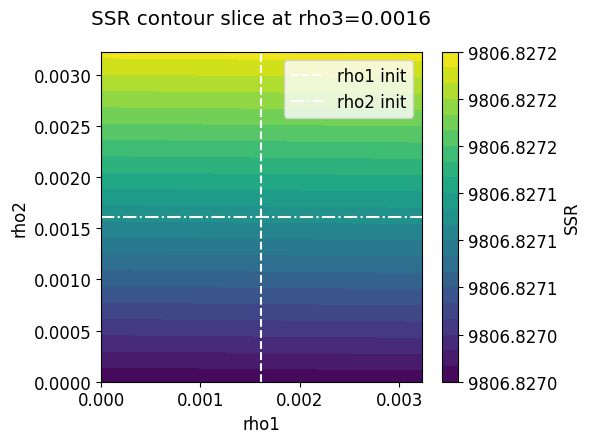

In [9]:
# 1) Recompute the initial‐guess and fix rho3 at its initial value
avg_nbrs      = W.sum(axis=1).mean()
initial_guess = np.repeat(1.0 / avg_nbrs, M)
rho3_fixed    = initial_guess[2]

# 2) Build the rho1–rho2 grid and evaluate the FAST SSR
n1, n2    = 30, 30
rho1_vals = np.linspace(0, 2 * initial_guess[0], n1)
rho2_vals = np.linspace(0, 2 * initial_guess[1], n2)
SSR_grid  = np.empty((n1, n2))

for i, r1 in enumerate(rho1_vals):
    for j, r2 in enumerate(rho2_vals):
        SSR_grid[i, j] = ssr_fast([r1, r2, rho3_fixed])

# 3) Plot setup
fig, ax = plt.subplots(figsize=(6, 5))

# 4) Filled contour
contour = ax.contourf(
    rho1_vals, rho2_vals, SSR_grid.T,
    levels=20, cmap='viridis'
)

# 5) Single colorbar, fixed‐point ticks, no offset
cbar = fig.colorbar(contour, ax=ax, label='SSR')
cbar.ax.yaxis.offsetText.set_visible(False)
cbar.formatter = FormatStrFormatter('%.4f')
cbar.update_ticks()

# 6) Initial‐guess reference lines
ax.axvline(initial_guess[0], color='white', linestyle='--', label='rho1 init')
ax.axhline(initial_guess[1], color='white', linestyle='-.', label='rho2 init')

# 7) Labels, legend, and title (padded to avoid overlap)
ax.set_xlabel('rho1')
ax.set_ylabel('rho2')
ax.legend(loc='upper right')
ax.set_title(f'SSR contour slice at rho3={rho3_fixed:.4f}', pad=20)

# 8) Tight layout with extra top margin and save
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("/content/drive/My Drive/Master_Thesis/event_study_spatial_highO_rho_opt.png", dpi=1000, bbox_inches="tight")
plt.show()

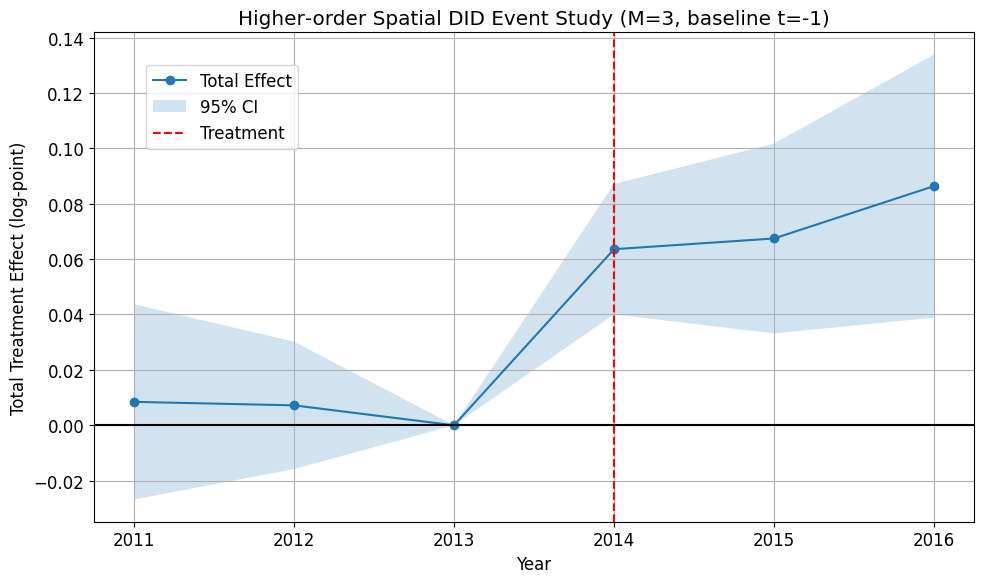

In [10]:
# choose bounds
bounds = [(0, None)] * M

res = minimize(ssr_fast, x0=initial_guess, bounds=bounds)
rhos = res.x

# --- PART 3: Final spatial interactions ---
W_tot = sum(rhos[i] * W_powers[i] for i in range(M))
WX    = W_tot.dot(Xd)

spatial_cols = []
for i, dc in enumerate(direct_cols):
    sc = f"spatial_{dc}"
    df[sc] = WX[:, i]
    spatial_cols.append(sc)

# --- PART 4: Final regression with clustering & FEs via Patsy ---
all_terms = direct_cols + spatial_cols
formula = (
    "np.log(Output) ~ np.log(Capital) + np.log(Labor) + "
    + " + ".join(all_terms)
    + " + C(INN) + C(Year)"
)
model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={
        'groups': df['INN'],    # cluster by entity
        'groups2': df['Year']   # cluster by time
    }
)

# --- PART 5: Extract & combine coefs + correct SEs for plotting ---
p = model.params
bse = model.bse
vc = model.cov_params()

def parse_t(name, prefix):
    core = name.replace(prefix, '').split('_')[-1]
    return -int(core.replace('minus','')) if core.startswith('minus') else int(core)

direct_dict  = {}
spatial_dict = {}
for name, coef in p.items():
    if name.startswith('direct_event_t_'):
        t = parse_t(name, 'direct_event_t_')
        direct_dict[t]  = (coef, bse[name])
    elif name.startswith('spatial_direct_event_t_'):
        t = parse_t(name, 'spatial_direct_event_t_')
        spatial_dict[t] = (coef, bse[name])

effects = {}
for t in sorted(set(direct_dict) | set(spatial_dict)):
    dc, dse = direct_dict.get(t,  (0.0,0.0))
    sc, sse = spatial_dict.get(t, (0.0,0.0))
    dn = f"direct_event_t_{t}"        if t>=0 else f"direct_event_t_minus{abs(t)}"
    sn = f"spatial_direct_event_t_{t}" if t>=0 else f"spatial_direct_event_t_minus{abs(t)}"
    vd = vc.at[dn, dn] if dn in vc.index else 0.0
    vs = vc.at[sn, sn] if sn in vc.index else 0.0
    cds= vc.at[dn, sn] if (dn in vc.index and sn in vc.index) else 0.0
    effects[t] = (dc+sc, np.sqrt(vd+vs+2*cds))

plot_df = pd.DataFrame({
    'event_time': list(effects),
    'coef':        [v[0] for v in effects.values()],
    'se':          [v[1] for v in effects.values()]
})
if -1 not in plot_df['event_time'].values:
    plot_df = pd.concat([plot_df, pd.DataFrame({'event_time':[-1],'coef':[0],'se':[0]})], ignore_index=True)
plot_df.sort_values('event_time', inplace=True)
plot_df['year'] = plot_df['event_time'] + treatment_year

# --- PART 6: Plot the event‐study ---
plt.figure(figsize=(10,6))
plt.plot( plot_df['year'], plot_df['coef'], marker='o', label='Total Effect' )
plt.fill_between(
    plot_df['year'],
    plot_df['coef'] - 1.96*plot_df['se'],
    plot_df['coef'] + 1.96*plot_df['se'],
    alpha=0.2, label='95% CI'
)
plt.axvline(treatment_year, color='red', linestyle='--', label='Treatment')
plt.axhline(0, color='black')
plt.xlabel('Year')
plt.ylabel('Total Treatment Effect (log‐point)')
plt.title(f'Higher‐order Spatial DID Event Study (M={M}, baseline t=-1)')
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Master_Thesis/event_study_spatial_highO.png", dpi=1000, bbox_inches="tight")
plt.show()

In [11]:
print(f'Average number of neighbors per firm:{avg_nbrs}')

Average number of neighbors per firm:619.9039095619406


# Models

### DID
$$
\mathbf{Y} =
\beta_0 \underbrace{\mathbf{\iota}}_{NT \times 1}
+ \underbrace{\mathbf{X}}_{NT \times K} \underbrace{\alpha}_{K \times 1}
+ \beta_1 \underbrace{\mathbf{D}}_{NT \times 1}
+ \beta_2 \underbrace{\mathbf{T}}_{NT \times 1}
+ \beta_3 \underbrace{(\mathbf{D} \circ \mathbf{T})}_{NT \times 1}
+ \underbrace{\boldsymbol{\varepsilon}}_{NT \times 1}
$$

In [12]:
# -------------------------------
# Data Preparation for DiD
# -------------------------------
# Make a copy of balanced panel
df_did = balanced_df.copy()

# Create log-transformed variables for Output, Capital, and Labor.
df_did['ln_Output'] = np.log(df_did['Output'])
df_did['ln_Capital'] = np.log(df_did['Capital'])
df_did['ln_Labor'] = np.log(df_did['Labor'])

df_did['D'] = df_did['Treated_d']
df_did['T'] = df_did['Post_d']

# Check the unique time values
print("Unique Years:", df_did['Year'].unique())
print("Unique values for T (post dummy):", df_did['T'].unique())
print("Unique values for D (treatment dummy):", df_did['D'].unique())

# -------------------------------
# DiD Regression
# -------------------------------
# The DID formula is now:
formula = "ln_Output ~ ln_Capital + ln_Labor + D * T"

# Estimate the model using OLS with clustered standard errors by INN and year.
did_model = smf.ols(formula=formula, data=df_did).fit(
    cov_type='cluster',
    cov_kwds={
        'groups':  df_did['INN'],    # cluster by entity
        'groups2': df_did['Year']    # cluster by time period
    }
)

# Display the regression summary.
print(did_model.summary())

Unique Years: [2011 2012 2013 2014 2015 2016]
Unique values for T (post dummy): [0 1]
Unique values for D (treatment dummy): [1 0]
                            OLS Regression Results                            
Dep. Variable:              ln_Output   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     4174.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        06:39:25   Log-Likelihood:                -84903.
No. Observations:               50952   AIC:                         1.698e+05
Df Residuals:                   50946   BIC:                         1.699e+05
Df Model:                           5                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]


With FE:

$$
\mathbf{Y} =
\underbrace{\mathbf{X}}_{NT \times K} \underbrace{\alpha}_{K \times 1}
+ \beta_3 \underbrace{(\mathbf{D} \circ \mathbf{T})}_{NT \times 1}
+ FE_{\mathrm{i}} + FE_{\mathrm{t}}
+ \underbrace{\boldsymbol{\varepsilon}}_{NT \times 1}
$$

In [13]:
# --- Data Preparation ---
df_did_fe = balanced_df.copy()

# Log‐transform Output, Capital, and Labor
df_did_fe['ln_Output']  = np.log(df_did_fe['Output'])
df_did_fe['ln_Capital'] = np.log(df_did_fe['Capital'])
df_did_fe['ln_Labor']   = np.log(df_did_fe['Labor'])

# Define treatment and post dummies
df_did_fe['D'] = df_did_fe['Treated_d']
df_did_fe['T'] = df_did_fe['Post_d']

# Create the DiD interaction
df_did_fe['D_T'] = df_did_fe['D'] * df_did_fe['T']

# Set up panel indexing
df_did_fe = df_did_fe.set_index(['INN', 'Year'])

# Outcome and regressors (no const, since FEs soak it up)
endog = df_did_fe['ln_Output']
exog  = df_did_fe[['ln_Capital', 'ln_Labor', 'D_T']]

# --- Two‐way FE DiD via the within estimator ---
# set the АFE model
mod_within = PanelOLS(
    endog,
    exog,
    entity_effects=True,
    time_effects=True
)
# estimate it
did_fe_model = mod_within.fit(
    cov_type='clustered',
    cluster_entity=True,
    cluster_time=True
)

print(did_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Output   R-squared:                        0.2728
Estimator:                   PanelOLS   R-squared (Between):              0.8649
No. Observations:               50952   R-squared (Within):               0.3378
Date:                Mon, May 12 2025   R-squared (Overall):              0.8578
Time:                        06:39:25   Log-likelihood                -3.032e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5308.8
Entities:                        8492   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                 F(3,42452)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             243.69
                            

In [14]:
# -------------------------------
# Helper Functions
# -------------------------------
def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    # Try the variable name as given.
    if var in model.params:
        coef = model.params[var]
        se = model.bse[var] if hasattr(model, 'bse') else model.std_errors[var]
        p = model.pvalues[var]
    else:
        # If not found, try replacing ":" with "_" (e.g., "D:T" -> "D_T")
        alt_var = var.replace(":", "_")
        if alt_var in model.params:
            coef = model.params[alt_var]
            se = model.bse[alt_var] if hasattr(model, 'bse') else model.std_errors[alt_var]
            p = model.pvalues[alt_var]
        else:
            return ""
    star_str = stars_from_p(p)
    return f"{coef:.3f}{star_str}\n({se:.3f})"

# -------------------------------
# Build Formatted DID Results Using the Within Estimator for FE
# -------------------------------
# Define the key variables to display. Now includes ln_Labor.
coef_vars = ["ln_Capital", "ln_Labor", "D", "T", "D:T"]

# Directly create the final formatted results table as results_did.
results_did = pd.DataFrame({var: {"DID": format_coef(did_model, var),
                                  "DID (FE)": format_coef(did_fe_model, var)}
                             for var in coef_vars}).T

# Append summary rows for N and FE (using the actual values from the models).
results_did.loc["N"] = [f"{int(did_model.nobs)}", f"{int(did_fe_model.nobs)}"]
results_did.loc["FE"] = ["No", "Yes"]

# Add the OLS intercept row
results_did.loc["Intercept"] = [
    format_coef(did_model, "Intercept"),
    ""                                    # blank for the FE column
]

# Move it to the top:
order = ["Intercept"] + [r for r in results_did.index if r != "Intercept"]
results_did = results_did.reindex(order)

results_did

,DID,DID (FE)
Intercept,-1.509***\n(0.068),
ln_Capital,0.405***\n(0.009),0.055\n(0.034)
ln_Labor,1.017***\n(0.016),1.107***\n(0.046)
D,-0.241***\n(0.034),
T,-0.073***\n(0.016),
D:T,0.035**\n(0.018),0.067***\n(0.016)
N,50952,50952
FE,No,Yes


### SDID

$$
Y =
\beta_0 \iota
+ \mathbf{X} \alpha
+ \beta_1 \mathbf{D}
+ \beta_2 \mathbf{T}
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 (\underbrace{\mathbf{W_{NT}}}_{NT \times NT}\mathbf{D} \circ \mathbf{T})
+ \boldsymbol{\varepsilon}
$$

In [15]:
# ================================
# PART 1: Data Preparation for Spatial DID
# ================================
df_spatial = balanced_df.copy()
W_NT_sub = W_NT_sparse

# Create log-transformed variables.
df_spatial['ln_Output'] = np.log(df_spatial['Output'])
df_spatial['ln_Capital'] = np.log(df_spatial['Capital'])
df_spatial['ln_Labor'] = np.log(df_spatial['Labor'])  # Added labor

# Define treatment indicator D and time dummy T.
df_spatial['D'] = df_spatial['Treated_d']
df_spatial['T'] = df_spatial['Post_d']

# Compute the spatial lag of D and then the spatial interaction term.
df_spatial['W_D'] = W_NT_sub.dot(df_spatial['D'].values)
df_spatial['W_D_T'] = df_spatial['W_D'] * df_spatial['T']

# ================================
# PART 2: Model Estimation for Spatial DID
# ================================
# Model 1: Non-FE Spatial DID (using smf.ols)
formula_spatial1 = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T + W_D_T"
sdid_model = smf.ols(formula=formula_spatial1, data=df_spatial).fit(
    cov_type='cluster',
    cov_kwds={
        'groups':  df_spatial['INN'],   # cluster by entity
        'groups2': df_spatial['Year']   # cluster by time period
    }
)
print(sdid_model.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_Output   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     3479.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        06:39:26   Log-Likelihood:                -84903.
No. Observations:               50952   AIC:                         1.698e+05
Df Residuals:                   50945   BIC:                         1.699e+05
Df Model:                           6                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5092      0.068    -22.205      0.0

With FE:

$$
Y =
 \mathbf{X} \alpha
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 (\underbrace{\mathbf{W_{NT}}}_{NT \times NT}\mathbf{D} \circ \mathbf{T})
+ FE_{\mathrm{t}} + FE_{\mathrm{i}} + \varepsilon_{it}
$$

In [16]:
# Model 2: FE Spatial DID using PanelOLS (Within Estimator)
df_spatial['D_T'] = df_spatial['D'] * df_spatial['T']

# Set the panel index.
df_panel = df_spatial.set_index(['INN', 'Year'])

# For the FE model, our regressors are: ln_Capital, ln_Labor, D_T, and W_D_T.
exog_vars = ['ln_Capital', 'ln_Labor', 'D_T', 'W_D_T']
exog = sm.add_constant(df_panel[exog_vars])
endog = df_panel['ln_Output']

within_model = PanelOLS(endog, exog, entity_effects=True, time_effects=True)
sdid_fe_model = within_model.fit(
    cov_type='clustered',
    cluster_entity=True,   # cluster by INN
    cluster_time=True      # cluster by Year
)

print(sdid_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Output   R-squared:                        0.2729
Estimator:                   PanelOLS   R-squared (Between):              0.5617
No. Observations:               50952   R-squared (Within):               0.3372
Date:                Mon, May 12 2025   R-squared (Overall):              0.5481
Time:                        06:39:27   Log-likelihood                -3.032e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3983.2
Entities:                        8492   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                 F(4,42451)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             207.75
                            

In [17]:
# ================================
# Create a Formatted Summary Table for Spatial DID
# ================================
coef_vars = ["ln_Capital", "ln_Labor", "D", "T", "D:T", "W_D_T"]

def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    # For the non-FE model (smf.ols), variable names are as given.
    if var in model.params:
        coef = model.params[var]
        se = model.bse[var]
        p = model.pvalues[var]
        return f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})"
    else:
        return ""

def format_coef_fe(model, var):
    # For the FE model via PanelOLS, note that the interaction D:T is reported as "D_T".
    if var in ['D', 'T']:
        # These are absorbed by FE, so we return blank.
        return ""
    if var == "D:T" and "D_T" in model.params:
        var = "D_T"
    if var in model.params:
        coef = model.params[var]
        se = model.std_errors[var]
        p = model.pvalues[var]
        return f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})"
    else:
        return ""

results_data = {}
for var in coef_vars:
    results_data[var] = {
        "Spatial DID": format_coef(sdid_model, var),
        "Spatial DID (FE)": format_coef_fe(sdid_fe_model, var)
    }
results_sdid = pd.DataFrame(results_data).T  # Final table named results_sdid

# Append summary rows for sample size (N) and FE indicator.
results_sdid.loc["N"] = [f"{int(sdid_model.nobs)}", f"{int(sdid_fe_model.nobs)}"]
results_sdid.loc["FE"] = ["No", "Yes"]

# Move the summary rows "N" and "FE" to the bottom.
new_order = [row for row in results_sdid.index if row not in ["N", "FE"]] + ["N", "FE"]
results_sdid = results_sdid.reindex(new_order)

#  Append the intercep
results_sdid.loc["Intercept"] = [
    format_coef(sdid_model, "Intercept"),
    ""                                     # leave Spatial DID (FE) blank
]

# "const" appears at the top
base_rows = [r for r in results_sdid.index if r not in ["Intercept", "N", "FE"]]
new_order = ["Intercept"] + base_rows + ["N", "FE"]
results_sdid = results_sdid.reindex(new_order)

results_sdid

,Spatial DID,Spatial DID (FE)
Intercept,-1.509***\n(0.068),
ln_Capital,0.405***\n(0.009),0.055\n(0.034)
ln_Labor,1.017***\n(0.016),1.107***\n(0.046)
D,-0.241***\n(0.034),
T,-0.077***\n(0.023),
D:T,0.035**\n(0.018),0.068***\n(0.016)
W_D_T,0.000\n(0.000),-0.000\n(0.000)
N,50952,50952
FE,No,Yes


### Higher order - unrestricted

$$
\mathbf{Y} =
\beta_0 \mathbf{\iota}
+ \mathbf{X} \alpha
+ \beta_1 \mathbf{D}
+ \beta_2 \mathbf{T}
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 \left( \sum\limits_{m=1}^{M}\rho_{m}\mathbf{W}_{NT}^{m}\right)\mathbf{D} \circ \mathbf{T}
+ \boldsymbol{\varepsilon}
$$

#### Choice of the optimal order

In [18]:
# ================================
# PART 0: Define Maximum Order H
# ================================
H = 5  # Maximum order of spatial lags to consider

# ================================
# PART 1: Data Preparation & Variable Construction
df_spatial_HO = balanced_df.copy()

# Create log-transformed variables for Output, Capital, and Labor.
df_spatial_HO['ln_Output'] = np.log(df_spatial_HO['Output'])
df_spatial_HO['ln_Capital'] = np.log(df_spatial_HO['Capital'])
df_spatial_HO['ln_Labor'] = np.log(df_spatial_HO['Labor'])

# Define treatment indicator D and time dummy T.
df_spatial_HO['D'] = df_spatial_HO['Treated_d']
df_spatial_HO['T'] = df_spatial_HO['Post_d']

# ================================
# PART 2: Compute Spatial Interaction Terms for m = 1,...,H
# ================================
# We will create new columns: for each order m, define W_D{m}_T = (W_NT_sub^m * D) * T.
# Start by computing the first order.
W_power = W_NT_sub.copy()  # This is W_NT_sub^1.
for m in range(1, H+1):
    col_name = f'W_D{m}_T'
    df_spatial_HO[col_name] = W_power.dot(df_spatial_HO['D'].values) * df_spatial_HO['T']
    # Update the power if not yet reached maximum order.
    if m < H:
        W_power = W_NT_sub.dot(W_power)

# ================================
# PART 3: Estimate Models for M = 1,...,H and Select Optimal M by BIC
# ================================
bic_values = {}
models = {}
for M in range(1, H+1):
    # Base formula now includes ln_Capital and ln_Labor along with D, T, and D:T.
    formula = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T"
    # Append spatial interaction terms for orders 1 to M.
    for m in range(1, M+1):
        formula += f" + W_D{m}_T"
    model_M = smf.ols(formula=formula, data=df_spatial_HO).fit(
        cov_type='cluster',
        cov_kwds={
            'groups': df_spatial_HO['INN'],   # cluster by entity
            'groups2': df_spatial_HO['Year']  # cluster by time
        }
    )
    bic_values[M] = model_M.bic
    models[M] = model_M
    print(f"M = {M}, BIC = {model_M.bic:.2f}")

optimal_M = min(bic_values, key=bic_values.get)
print("\nOptimal M =", optimal_M, "with BIC =", bic_values[optimal_M])

M = 1, BIC = 169882.43
M = 2, BIC = 169893.08
M = 3, BIC = 169901.72
M = 4, BIC = 169910.86
M = 5, BIC = 173615.72

Optimal M = 1 with BIC = 169882.43298771995


#### The optimal model

In [19]:
# ================================
# PART 0: Define Maximum Order Parameter
# ================================
# H_optimal = optimal_M # Maximum order of spatial lags to consider
H_optimal = 3 # not to intersect with the spatial DID model
# ================================
# PART 1: Data Preparation & Variable Construction for Extended Spatial DID (H_optimal)
# ================================
df_spatial_HO_reg = balanced_df.copy()

# Create log-transformed variables for Output and Capital.
df_spatial_HO_reg['ln_Output'] = np.log(df_spatial_HO_reg['Output'])
df_spatial_HO_reg['ln_Capital'] = np.log(df_spatial_HO_reg['Capital'])
df_spatial_HO_reg['ln_Labor'] = np.log(df_spatial_HO_reg['Labor'])

# Define treatment indicator D and time dummy T.
df_spatial_HO_reg['D'] = df_spatial_HO_reg['Treated_d']
df_spatial_HO_reg['T'] = df_spatial_HO_reg['Post_d']
# Create the interaction term D*T.
df_spatial_HO_reg['D_T'] = df_spatial_HO_reg['D'] * df_spatial_HO_reg['T']

# ================================
# PART 2: Compute Spatial Interaction Terms for m = 1,...,H_optimal
# ================================
# For each order m, compute: W_D{m}_T = (W_NT_sub^m * D) * T.
# For m=1, we name the column "W_D_T".
W_power = W_NT_sub.copy()  # This is W_NT_sub^1.
for m in range(1, H_optimal+1):
    if m == 1:
        col_name = "W_D_T"
    else:
        col_name = f"W_D{m}_T"
    df_spatial_HO_reg[col_name] = W_power.dot(df_spatial_HO_reg['D'].values) * df_spatial_HO_reg['T']
    if m < H_optimal:
        W_power = W_NT_sub.dot(W_power)

# ================================
# PART 3: Model Estimation for Extended Spatial DID (H_optimal)
# ================================
# Non-FE Extended Spatial DID Model via OLS.
formula_extended1 = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T"
for m in range(1, H_optimal+1):
    if m == 1:
        formula_extended1 += " + W_D_T"
    else:
        formula_extended1 += f" + W_D{m}_T"
hdid_model = smf.ols(formula=formula_extended1, data=df_spatial_HO_reg).fit(
    cov_type='cluster',
    cov_kwds={
        'groups': df_spatial_HO_reg['INN'],   # cluster by entity
        'groups2': df_spatial_HO_reg['Year']  # cluster by time
    }
)

hdid_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ln_Output   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     2817.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        07:00:51   Log-Likelihood:                -84902.
No. Observations:               50952   AIC:                         1.698e+05
Df Residuals:                   50943   BIC:                         1.699e+05
Df Model:                           8                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5094      0.068    -22.207      0.000      -1.643      -1.376
ln_Capital     0.4054      0.009     45.921      0.000       0.388       0.423
ln_Labor       1.0167      0.016     62.082      0.000       0.985       1.049
D             -0.2408      0.034     -7.141      0.000      -0.307      -0.175
T             -0.1065      0.038     -2.789      0.005      -0.181      -0.032
D:T            0.0345      0.018      1.954      0.051      -0.000       0.069
W_D_T          0.0005      0.000      1.218      0.223      -0.000       0.001
W_D2_T     -1.081e-06   8.87e-07     -1.219      0.223   -2.82e-06    6.57e-07
W_D3_T      6.407e-10   5.41e-10      1.184      0.237    -4.2e-10     1.7e-09
==============================================================================
Omnibus:                     4697.600   Durbin-Watson:                   0.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20819.707
Skew:                          -0.363   Prob(JB):                         0.00
Kurtosis:                       6.046   Cond. No.                     2.97e+09
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 2.97e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With FE:

$$
\mathbf{Y} =
 \mathbf{X} \alpha
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 \left( \sum\limits_{m=1}^{M}\rho_{m}\mathbf{W}_{NT}^{m}\right)\mathbf{D} \circ \mathbf{T}
+ FE_{\mathrm{t}} + FE_{\mathrm{i}}
+ \boldsymbol{\varepsilon}
$$

In [20]:
df_panel_HO = df_spatial_HO_reg.set_index(['INN', 'Year'])
exog_vars = ['ln_Capital', 'ln_Labor', 'D_T'] + [f"W_D_T"] + [f"W_D{m}_T" for m in range(2, H_optimal+1)]
exog = sm.add_constant(df_panel_HO[exog_vars])
endog = df_panel_HO['ln_Output']
within_model = PanelOLS(endog, exog, entity_effects=True, time_effects=True)

hdid_fe_model = within_model.fit(
    cov_type='clustered',
    cluster_entity=True,   # cluster by INN
    cluster_time=True      # cluster by Year
)

print(hdid_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Output   R-squared:                        0.2731
Estimator:                   PanelOLS   R-squared (Between):              0.5617
No. Observations:               50952   R-squared (Within):               0.3387
Date:                Mon, May 12 2025   R-squared (Overall):              0.5482
Time:                        07:00:51   Log-likelihood                -3.031e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2658.5
Entities:                        8492   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                 F(6,42449)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             141.39
                            

In [21]:
# ================================
# PART 4: Create a Summary Table
# ================================
ordered_vars = ["ln_Capital", "ln_Labor", "D", "T", "D:T"] + [f"W_D_T"] + [f"W_D{m}_T" for m in range(2, H_optimal+1)]

def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    # For the within estimator FE model, if "D:T" is not found, try "D_T".
    if var not in model.params:
        alt_var = var.replace(":", "_")
        if alt_var in model.params:
            var = alt_var
        else:
            return ""
    coef = model.params[var]
    se = model.bse[var] if hasattr(model, 'bse') else model.std_errors[var]
    p = model.pvalues[var]
    return f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})"

results_data = {}
for var in ordered_vars:
    results_data[var] = {
        "Unrestricted": format_coef(hdid_model, var),
        "Unrestricted (FE)": format_coef(hdid_fe_model, var)
    }
results_sdidH = pd.DataFrame(results_data).T  # Renamed final table to results_sdidH

# Add the OLS intercept row
results_sdidH.loc["Intercept"] = [
    format_coef(hdid_model, "Intercept"),
    ""                                    # blank for the FE column
]

# Move it to the top:
order = ["Intercept"] + [r for r in results_sdidH.index if r != "Intercept"]
results_sdidH = results_sdidH.reindex(order)

# Append summary rows for sample size (N) and FE indicator.
results_sdidH.loc["N"] = [f"{int(hdid_model.nobs)}", f"{int(hdid_fe_model.nobs)}"]
results_sdidH.loc["FE"] = ["No", "Yes"]

# Move the summary rows "N" and "FE" to the bottom.
new_order = [r for r in results_sdidH.index if r not in ["N", "FE"]] + ["N", "FE"]
results_sdidH = results_sdidH.reindex(new_order)
results_sdidH

,Unrestricted,Unrestricted (FE)
Intercept,-1.509***\n(0.068),
ln_Capital,0.405***\n(0.009),0.055\n(0.034)
ln_Labor,1.017***\n(0.016),1.107***\n(0.046)
D,-0.241***\n(0.034),
T,-0.107***\n(0.038),
D:T,0.034*\n(0.018),0.067***\n(0.016)
W_D_T,0.000\n(0.000),0.000*\n(0.000)
W_D2_T,-0.000\n(0.000),-0.000*\n(0.000)
W_D3_T,0.000\n(0.000),0.000*\n(0.000)
N,50952,50952


### Higher order - restricted

$$
\mathbf{Y} = \mathbf{X} \alpha
+ \beta_1 \mathbf{D}
+ \beta_2 \mathbf{T}
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 \left( \sum\limits_{m=1}^{M}\rho_{}^{m}\mathbf{W}_{NT}^{m}\right)\mathbf{D} \circ \mathbf{T}
+ \boldsymbol{\varepsilon},
$$
where $0<\rho<1$.

#### Choice of the optimal order

In [22]:
# -------------------------------
# balanced_df copy
# -------------------------------
df_spatial_HOR = balanced_df.copy()

# -------------------------------
# 1) Build the weight matrix (keep it sparse)
# -------------------------------

W_sub  = W_NT_sparse.copy()

# -------------------------------
# 2) Prepare data including D and T
# -------------------------------
df = df_spatial_HOR.copy()
df['ln_output']  = np.log(df['Output'])
df['ln_capital'] = np.log(df['Capital'])
df['ln_labor']   = np.log(df['Labor'])
df['d']          = df['Treated_d']
df['t']          = df['Post_d']
df['d_t']        = df['d'] * df['t']

y   = df['ln_output'].values                      # (n,)
X   = np.column_stack([
    np.ones(len(df)),
    df['ln_capital'].values,
    df['ln_labor'].values
])                                                 # (n,3)
d   = df['d'].values                              # (n,)
t   = df['t'].values                              # (n,)
d_t = df['d_t'].values                            # (n,)

# -------------------------------
# 3) Precompute W^m · d  for m = 1..H
# -------------------------------
H = 5
W_d_lags = []
w_prev = d.copy()  # we'll compute W^m d by successive multiplications
for m in range(1, H+1):
    w_next = W_sub.dot(w_prev)   # sparse dot
    W_d_lags.append(w_next)     # this is W^m d
    w_prev = w_next

# -------------------------------
# 4) Loop over M = 1..H, fit NLLS and compute BIC
# -------------------------------
n = y.size
results_by_M = {}
bic_by_M     = {}

# bounds and initial‐guess logic (shared across Ms)
# we have params = [a0,a1,a2,b1,b2,b3,b4,rho]
# initial guess from linear regression
lin_init = np.linalg.lstsq(
    np.column_stack([X, d, t, d_t]), y, rcond=None
)[0]
x0 = np.r_[lin_init[:3], lin_init[3], lin_init[4], lin_init[5], 1.0, 0.1]

lb = np.r_[
    -np.inf*np.ones(x0.size-1),
     1e-6
]
ub = np.r_[
     np.inf*np.ones(x0.size-1),
     0.9999
]

def make_residuals(M):
    def residuals(params):
        a0,a1,a2,b1,b2,b3,b4,rho = params
        # build weighted sum of the first M W^m d vectors
        Wsum_d = sum((rho**m) * W_d_lags[m-1] for m in range(1, M+1))
        fitted = (
            a0
          + a1 * X[:,1]
          + a2 * X[:,2]
          + b1 * d
          + b2 * t
          + b3 * d_t
          + b4 * (Wsum_d * t)
        )
        return y - fitted
    return residuals

for M in range(1, H+1):
    res = least_squares(
        make_residuals(M),
        x0,
        bounds=(lb, ub),
        xtol=1e-8,
        ftol=1e-8,
        verbose=0
    )
    results_by_M[M] = res
    ssr = np.sum(res.fun**2)
    k   = res.x.size
    bic_by_M[M] = n * np.log(ssr / n) + k * np.log(n)
    print(f"M={M}, SSR={ssr:.2f}, BIC={bic_by_M[M]:.2f}")

# -------------------------------
# 5) Select optimal M
# -------------------------------
opt_MR = min(bic_by_M, key=bic_by_M.get)
print(f"\nOptimal M = {opt_MR} with BIC = {bic_by_M[opt_MR]:.2f}")

M=1, SSR=83569.95, BIC=25297.76
M=2, SSR=83570.02, BIC=25297.80
M=3, SSR=83570.01, BIC=25297.80
M=4, SSR=83569.98, BIC=25297.78
M=5, SSR=83569.92, BIC=25297.74

Optimal M = 5 with BIC = 25297.74


#### The optimal model

In [23]:
# ===============================
# Restricted NLLS (no FE) – Optimized
# ===============================

# --- 0) Setup data and sparse weight matrix ---
df_spatial_HOR = balanced_df.copy()
W_NT_sub      = W_NT_sparse             # keep as sparse

# --- 1) Create ln and dummy vars ---
df = df_spatial_HOR.copy()
df['ln_output']  = np.log(df['Output'])
df['ln_capital'] = np.log(df['Capital'])
df['ln_labor']   = np.log(df['Labor'])
df['d']          = df['Treated_d']
df['t']          = df['Post_d']
df['d_t']        = df['d'] * df['t']

# --- 2) Prepare arrays ---
y   = df['ln_output'].values                    # (n,)
X   = np.column_stack([
    np.ones(len(df)),
    df['ln_capital'].values,
    df['ln_labor'].values
])                                               # (n,3)
d   = df['d'].values                            # (n,)
t   = df['t'].values                            # (n,)
d_t = df['d_t'].values                          # (n,)

# --- 3) Precompute W^m · d vectors up to max_order ---
max_order = opt_MR
W_powers  = []
w_prev    = d.copy()
for m in range(1, max_order+1):
    w_prev = W_NT_sub.dot(w_prev)   # sparse dot
    W_powers.append(w_prev)        # W_powers[m-1] = W^m · d

# --- 4) Define the residual function (same signature) ---
def residuals_all(params, y, X, d, t, d_t, W_powers):
    a0,a1,a2,b1,b2,b3,b4,rho = params
    # sum_{m=1}^M rho^m W^m d
    Wsum_d = sum((rho**(m+1)) * W_powers[m] for m in range(len(W_powers)))
    fitted = (
        a0
      + a1 * X[:,1]
      + a2 * X[:,2]
      + b1 * d
      + b2 * t
      + b3 * d_t
      + b4 * (Wsum_d * t)
    )
    return y - fitted

# --- 5) Initial guess and bounds (unchanged) ---
init_ab = np.linalg.lstsq(
    np.hstack([X, d.reshape(-1,1), t.reshape(-1,1), d_t.reshape(-1,1)]),
    y,
    rcond=None
)[0]  # gives [a0,a1,a2,b1,b2,b3]
x0 = np.r_[init_ab[:6], 1.0, 0.1]  # [a0,a1,a2,b1,b2,b3, b4=1, rho=0.1]

num_params   = x0.size
lower_bounds = np.r_[-np.inf*np.ones(num_params-1), 1e-6]
upper_bounds = np.r_[ np.inf*np.ones(num_params-1), 0.9999]

# --- 6) Solve by NLLS ---
result = least_squares(
    residuals_all,
    x0,
    bounds=(lower_bounds, upper_bounds),
    args=(y, X, d, t, d_t, W_powers),
    xtol=1e-8, ftol=1e-8, verbose=0
)

# --- 7) Extract estimates & Hessian‐based SEs ---
params  = result.x
J       = result.jac
ssr     = np.sum(result.fun**2)
sigma2  = ssr / (y.size - num_params)
cov_mat = np.linalg.inv(J.T.dot(J)) * sigma2
se_all  = np.sqrt(np.diag(cov_mat))

alpha0, alpha1, alpha2, beta1, beta2, beta3, beta4, rho = params

# --- 8) Two‐way cluster‐robust SEs ---
resid      = result.fun            # (n_obs,)
p          = J.shape[1]
scores     = -resid[:, None] * J    # (n_obs, p)

# cluster IDs
entity_ids = pd.factorize(df['INN'])[0]
time_ids   = pd.factorize(df['Year'])[0]

def cluster_meat(scores, clusters):
    uniq = np.unique(clusters)
    M = np.zeros((p, p))
    for g in uniq:
        idx = np.where(clusters == g)[0]
        Sg  = scores[idx].sum(axis=0).reshape(p,1)
        M  += Sg @ Sg.T
    return M

M_e  = cluster_meat(scores, entity_ids)
M_t  = cluster_meat(scores, time_ids)
M_i  = scores.T @ scores
Hmat = J.T @ J
Hinv = np.linalg.inv(Hmat)
V2w  = Hinv @ (M_e + M_t - M_i) @ Hinv
se_cl = np.sqrt(np.diag(V2w))

# --- 9) Print results with both SEs ---
print("Restricted NLLS estimates (with D and T):")
print(f"intercept     = {alpha0:.6f} (SE_hess={se_all[0]:.6f}, SE_cl={se_cl[0]:.6f})")
print(f"ln_capital    = {alpha1:.6f} (SE_hess={se_all[1]:.6f}, SE_cl={se_cl[1]:.6f})")
print(f"ln_labor      = {alpha2:.6f} (SE_hess={se_all[2]:.6f}, SE_cl={se_cl[2]:.6f})")
print(f"beta1 (D)     = {beta1:.6f} (SE_hess={se_all[3]:.6f}, SE_cl={se_cl[3]:.6f})")
print(f"beta2 (T)     = {beta2:.6f} (SE_hess={se_all[4]:.6f}, SE_cl={se_cl[4]:.6f})")
print(f"beta3 (D×T)   = {beta3:.6f} (SE_hess={se_all[5]:.6f}, SE_cl={se_cl[5]:.6f})")
print(f"beta4         = {beta4:.6f} (SE_hess={se_all[6]:.6f}, SE_cl={se_cl[6]:.6f})")
print(f"rho           = {rho:.6f} (SE_hess={se_all[7]:.6f}, SE_cl={se_cl[7]:.6f})\n")

for m, w_vec in enumerate(W_powers, start=1):
    coef_m   = beta4 * (rho**m)
    v1       = (rho**m)**2 * cov_mat[6,6]
    v2       = (m * beta4 * rho**(m-1))**2 * cov_mat[7,7]
    v3       = 2 * (rho**m) * (m * beta4 * rho**(m-1)) * cov_mat[6,7]
    se_m_h   = np.sqrt(v1 + v2 + v3)
    print(f"W^{m}·d_t coef (m={m}) = {coef_m:.6f} (SE_hess={se_m_h:.6f})")

Restricted NLLS estimates (with D and T):
intercept     = -1.509176 (SE_hess=0.029205, SE_cl=0.095299)
ln_capital    = 0.405444 (SE_hess=0.003055, SE_cl=0.079790)
ln_labor      = 1.016645 (SE_hess=0.006307, SE_cl=0.053431)
beta1 (D)     = -0.240854 (SE_hess=0.019155, SE_cl=0.063709)
beta2 (T)     = -0.075512 (SE_hess=0.025441, SE_cl=0.053986)
beta3 (D×T)   = 0.034737 (SE_hess=0.026899, SE_cl=nan)
beta4         = 0.000000 (SE_hess=0.000000, SE_cl=0.000000)
rho           = 0.099999 (SE_hess=644.223564, SE_cl=829.974846)

W^1·d_t coef (m=1) = 0.000000 (SE_hess=0.000000)
W^2·d_t coef (m=2) = 0.000000 (SE_hess=0.000000)
W^3·d_t coef (m=3) = 0.000000 (SE_hess=0.000000)
W^4·d_t coef (m=4) = 0.000000 (SE_hess=0.000000)
W^5·d_t coef (m=5) = 0.000000 (SE_hess=0.000000)


In [24]:
# 1) Copy parameter estimates and standard errors
# result.x = [alpha0, alpha1, alpha2, beta1, beta2, beta3, beta4, rho]
params_rest = result.x.copy()    # length 8
se_rest     = se_all.copy()      # length 8

# 2) Compute implied spatial‐lag coefficients and SEs for m=1..opt_MR
var_b4      = cov_mat[6,6]      # Var(beta4)
var_rho     = cov_mat[7,7]      # Var(rho)
cov_b4_rho  = cov_mat[6,7]      # Cov(beta4, rho)

spatial_rest = []
for m in range(1, opt_MR+1):
    coef_m = params_rest[6] * (params_rest[7]**m)  # beta4 * rho^m
    v1     = (params_rest[7]**m)**2 * var_b4
    v2     = (m * params_rest[6] * params_rest[7]**(m-1))**2 * var_rho
    v3     = 2 * (params_rest[7]**m) * (m * params_rest[6] * params_rest[7]**(m-1)) * cov_b4_rho
    se_m   = np.sqrt(v1 + v2 + v3)
    spatial_rest.append((coef_m, se_m))

# Now:
# params_rest  = numpy array [alpha0, alpha1, alpha2, beta1, beta2, beta3, beta4, rho]
# se_rest      = corresponding SE array
# spatial_rest = list of (coef, SE) for each spatial lag order 1..opt_MR


with FE:
$$
\mathbf{Y} =  
\mathbf{X} \alpha
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 \left( \sum\limits_{m=1}^{M}\rho_{}^{m}\mathbf{W}_{NT}^{m}\right)\mathbf{D} \circ \mathbf{T}
+ FE_{\mathrm{t}} + FE_{\mathrm{i}}
+ \boldsymbol{\varepsilon},
$$
where $0<\rho<1$.

In [25]:
# ================================
# Two‐way FE NLLS (within estimator) – Memory‐Optimized
# ================================
# --- 0) Setup data and sparse weight matrix ---
df_spatial_HOR_FE = balanced_df.copy()
W_sub             = W_NT_sparse  # keep sparse

# --- 1) Create transformed variables ---
df = df_spatial_HOR_FE
df['ln_output']  = np.log(df['Output'])
df['ln_capital'] = np.log(df['Capital'])
df['ln_labor']   = np.log(df['Labor'])
df['d_t']        = df['Treated_d'] * df['Post_d']

# --- entity and time indices for within‐demeaning ---
entity_ids = pd.factorize(df['INN'])[0]
time_ids   = pd.factorize(df['Year'])[0]

# --- 2) Prepare arrays ---
y   = df['ln_output'].values   # (n,)
x1  = df['ln_capital'].values  # (n,)
x2  = df['ln_labor'].values    # (n,)
dt  = df['d_t'].values         # (n,)

# --- 3) Precompute W^m · dt vectors up to H ---
H          = opt_MR
W_dt_lags  = []
w_prev_dt  = dt.copy()
for m in range(1, H+1):
    w_prev_dt = W_sub.dot(w_prev_dt)
    W_dt_lags.append(w_prev_dt)

# --- 4) Helper: double-demean a vector ---
def double_demean(A):
    arr = A.ravel()
    # subtract entity means
    arr = arr - pd.Series(arr).groupby(entity_ids).transform('mean').values
    # subtract time means and add grand mean
    arr = arr - pd.Series(arr).groupby(time_ids).transform('mean').values
    arr = arr + arr.mean()
    return arr

# --- 5) Residual function including within-demeaning ---
def residuals_FE(params):
    a1, a2, b3, b4, rho = params
    Wsum_dt = sum((rho**m) * W_dt_lags[m-1] for m in range(1, H+1))
    fit = a1*x1 + a2*x2 + b3*dt + b4*Wsum_dt
    err = y - fit
    return double_demean(err)

# --- 6) Initial guess and bounds ---
X0       = np.column_stack([x1, x2, dt])
init_ols = np.linalg.lstsq(X0, y, rcond=None)[0]
x0       = np.r_[init_ols[0], init_ols[1], init_ols[2], 1.0, 0.1]

lb = np.array([-np.inf, -np.inf, -np.inf, -np.inf, 1e-6])
ub = np.array([ np.inf,  np.inf,  np.inf,  np.inf, 0.9999])

# --- 7) Solve NLLS ---
res = least_squares(
    residuals_FE, x0,
    bounds=(lb, ub),
    xtol=1e-8, ftol=1e-8, verbose=0
)

# --- 8) Extract estimates and Hessian‐based SEs ---
a1, a2, b3, b4, rho = res.x
J      = res.jac
ssr    = np.sum(res.fun**2)
sigma2 = ssr / (y.size - len(res.x))
cov    = np.linalg.inv(J.T.dot(J)) * sigma2
se_hess= np.sqrt(np.diag(cov))

# --- 9) Two‐way cluster‐robust SEs ---
resid   = res.fun
p       = J.shape[1]
scores  = -resid[:, None] * J

def cluster_meat(scores, clusters):
    uniq = np.unique(clusters)
    M = np.zeros((p, p))
    for g in uniq:
        idx = np.where(clusters == g)[0]
        Sg  = scores[idx].sum(axis=0).reshape(p,1)
        M  += Sg @ Sg.T
    return M

M_e   = cluster_meat(scores, entity_ids)
M_t   = cluster_meat(scores, time_ids)
M_i   = scores.T @ scores
Hmat  = J.T @ J
Hinv  = np.linalg.inv(Hmat)
V2w   = Hinv @ (M_e + M_t - M_i) @ Hinv
se_cl = np.sqrt(np.diag(V2w))

# --- 10) Print results ---
print("Two-way FE NLLS estimates (no intercept):")
print(f"ln_capital  = {a1:.6f} (SE_hess={se_hess[0]:.6f}, SE_cl={se_cl[0]:.6f})")
print(f"ln_labor    = {a2:.6f} (SE_hess={se_hess[1]:.6f}, SE_cl={se_cl[1]:.6f})")
print(f"beta3 (D×T)= {b3:.6f} (SE_hess={se_hess[2]:.6f}, SE_cl={se_cl[2]:.6f})")
print(f"beta4       = {b4:.6f} (SE_hess={se_hess[3]:.6f}, SE_cl={se_cl[3]:.6f})")
print(f"rho         = {rho:.6f} (SE_hess={se_hess[4]:.6f}, SE_cl={se_cl[4]:.6f})")
print("\nImplied spatial-lag coefficients (m=1…H):")
var_b4     = cov[3,3]
var_rho    = cov[4,4]
cov_b4_rho = cov[3,4]
for m in range(1, H+1):
    coef_m = b4 * (rho**m)
    v1     = (rho**m)**2 * var_b4
    v2     = (m * b4 * rho**(m-1))**2 * var_rho
    v3     = 2*(rho**m)*(m * b4 * rho**(m-1))*cov_b4_rho
    se_m   = np.sqrt(v1 + v2 + v3)
    print(f"m={m:2d}: W^{m}(D×T) coef = {coef_m:.6f} (SE={se_m:.6f})")

Two-way FE NLLS estimates (no intercept):
ln_capital  = 0.054911 (SE_hess=0.002216, SE_cl=0.031407)
ln_labor    = 1.106885 (SE_hess=0.008375, SE_cl=0.042200)
beta3 (D×T)= 0.067211 (SE_hess=0.009226, SE_cl=0.014845)
beta4       = -0.000000 (SE_hess=0.000000, SE_cl=0.000000)
rho         = 0.100000 (SE_hess=218.986118, SE_cl=250.778091)

Implied spatial-lag coefficients (m=1…H):
m= 1: W^1(D×T) coef = -0.000000 (SE=0.000000)
m= 2: W^2(D×T) coef = -0.000000 (SE=0.000000)
m= 3: W^3(D×T) coef = -0.000000 (SE=0.000000)
m= 4: W^4(D×T) coef = -0.000000 (SE=0.000000)
m= 5: W^5(D×T) coef = -0.000000 (SE=0.000000)


In [26]:
# store results
# res.x contains [a1, a2, b3, b4, rho]
params_fe = res.x.copy()
# Standard errors: se_fe is array [SE_a1, SE_a2, SE_b3, SE_b4, SE_rho]
se_fe = se_cl.copy()  # from FE covariance

# Compute implied spatial‐lag coefs and their SEs for m=1..opt_MR
var_b4_fe   = cov[3,3]
var_rho_fe  = cov[4,4]
cov_b4_rho_fe = cov[3,4]

spatial_fe = []
for m in range(1, opt_MR+1):
    coef_m = params_fe[3] * (params_fe[4]**m)
    v1 = (params_fe[4]**m)**2 * var_b4_fe
    v2 = (m * params_fe[3] * params_fe[4]**(m-1))**2 * var_rho_fe
    v3 = 2 * (params_fe[4]**m) * (m * params_fe[3] * params_fe[4]**(m-1)) * cov_b4_rho_fe
    se_m = np.sqrt(v1 + v2 + v3)
    spatial_fe.append((coef_m, se_m))

In [27]:
def stars_from_p(p):
    if p < 0.01:   return '***'
    # elif p < 0.05: return '**'
    elif p < 0.1:  return '*'
    else:          return ''

# 1) How many spatial lags
M_est = len(spatial_rest)
# Build their row‐names: first order is W_D_T, then W_D2_T… up to M_est
spatial_names = ["W_D_T"] + [f"W_D{m}_T" for m in range(2, M_est+1)]

# 2) Complete row list
rows = [
    "Intercept",
    "ln_Capital",
    "ln_Labor",
    "D",
    "T",
    "D:T"
] + spatial_names

# 3) Build Restricted (No FE) column from NLLS params_rest & se_rest
restricted = []
# (i) Intercept
restricted.append(f"{params_rest[0]:.3f}{stars_from_p(2*(1-norm.cdf(abs(params_rest[0]/se_rest[0]))))}\n({se_rest[0]:.3f})")
# (ii) ln_Capital, ln_Labor, D, T, D:T
for i in range(1,6):
    coef = params_rest[i]
    se   = se_rest[i]
    p    = 2*(1 - norm.cdf(abs(coef/se)))
    restricted.append(f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})")
# (iii) spatial lags
for coef, se in spatial_rest:
    p = 2*(1 - norm.cdf(abs(coef/se)))
    restricted.append(f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})")

# 4) Build Restricted (FE) column from FE‐NLLS params_fe & se_fe
fe = []
for r in rows:
    if r in ("Intercept","D","T"):
        fe.append("")                  # absorbed by FE
    elif r=="ln_Capital":
        coef, se = params_fe[0], se_fe[0]
        p = 2*(1 - norm.cdf(abs(coef/se)))
        fe.append(f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})")
    elif r=="ln_Labor":
        coef, se = params_fe[1], se_fe[1]
        p = 2*(1 - norm.cdf(abs(coef/se)))
        fe.append(f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})")
    elif r=="D:T":
        coef, se = params_fe[2], se_fe[2]
        p = 2*(1 - norm.cdf(abs(coef/se)))
        fe.append(f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})")
    else:
        # spatial FE lags in spatial_fe
        idx = spatial_names.index(r)
        coef, se = spatial_fe[idx]
        p = 2*(1 - norm.cdf(abs(coef/se)))
        fe.append(f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})")

# 5) Assemble the DataFrame and append N, FE
results_sdidHRes = pd.DataFrame({
    "Restricted": restricted,
    "Restricted (FE)":    fe
}, index=rows)

# N & FE are already known
results_sdidHRes.loc["N"]  = [f"{int(hdid_model.nobs)}", f"{int(hdid_fe_model.nobs)}"]
results_sdidHRes.loc["FE"] = ["No","Yes"]

# 6) Display
display(results_sdidHRes)

,Restricted,Restricted (FE)
Intercept,-1.509***\n(0.029),
ln_Capital,0.405***\n(0.003),0.055*\n(0.031)
ln_Labor,1.017***\n(0.006),1.107***\n(0.042)
D,-0.241***\n(0.019),
T,-0.076***\n(0.025),
D:T,0.035\n(0.027),0.067***\n(0.015)
W_D_T,0.000\n(0.000),-0.000\n(0.000)
W_D2_T,0.000\n(0.000),-0.000\n(0.000)
W_D3_T,0.000\n(0.000),-0.000\n(0.000)
W_D4_T,0.000\n(0.000),-0.000\n(0.000)


### Final table

In [28]:
# ================================
# Final Combined Table (with NaNs replaced by blanks)
# ================================

import pandas as pd

# 1) Concatenate side-by-side
combined = pd.concat(
    [results_did,
     results_sdid,
     results_sdidH,
     results_sdidHRes],
    axis=1,
    keys=["DID", "Spatial DID", "Unrestricted", "Restricted"]
)

# 2) Flatten to single-level column names
combined.columns = combined.columns.get_level_values(1)

# 3) Build desired row order:
base = ["Intercept", "ln_Capital", "ln_Labor", "D", "T", "D:T", "W_D_T"]
others = sorted(
    [r for r in combined.index if r.startswith("W_D") and r != "W_D_T"],
    key=lambda r: int(r.split("_")[1][1:])
)
row_order = base + others + ["N", "FE"]

# 4) Reindex, replace NaNs with blanks, and display
combined = combined.reindex(row_order).fillna("")
display(combined)


,DID,DID (FE),Spatial DID,Spatial DID (FE),Unrestricted,Unrestricted (FE),Restricted,Restricted (FE)
Intercept,-1.509***\n(0.068),,-1.509***\n(0.068),,-1.509***\n(0.068),,-1.509***\n(0.029),
ln_Capital,0.405***\n(0.009),0.055\n(0.034),0.405***\n(0.009),0.055\n(0.034),0.405***\n(0.009),0.055\n(0.034),0.405***\n(0.003),0.055*\n(0.031)
ln_Labor,1.017***\n(0.016),1.107***\n(0.046),1.017***\n(0.016),1.107***\n(0.046),1.017***\n(0.016),1.107***\n(0.046),1.017***\n(0.006),1.107***\n(0.042)
D,-0.241***\n(0.034),,-0.241***\n(0.034),,-0.241***\n(0.034),,-0.241***\n(0.019),
T,-0.073***\n(0.016),,-0.077***\n(0.023),,-0.107***\n(0.038),,-0.076***\n(0.025),
D:T,0.035**\n(0.018),0.067***\n(0.016),0.035**\n(0.018),0.068***\n(0.016),0.034*\n(0.018),0.067***\n(0.016),0.035\n(0.027),0.067***\n(0.015)
W_D_T,,,0.000\n(0.000),-0.000\n(0.000),0.000\n(0.000),0.000*\n(0.000),0.000\n(0.000),-0.000\n(0.000)
W_D2_T,,,,,-0.000\n(0.000),-0.000*\n(0.000),0.000\n(0.000),-0.000\n(0.000)
W_D3_T,,,,,0.000\n(0.000),0.000*\n(0.000),0.000\n(0.000),-0.000\n(0.000)
W_D4_T,,,,,,,0.000\n(0.000),-0.000\n(0.000)


In [29]:
# 1) Build an “expanded” DataFrame where SEs are on a separate row
expanded_rows = []
expanded_idx  = []

for idx, row in combined.iterrows():
    if idx in ["N", "FE"]:
        # keep the summary rows as is
        expanded_rows.append(row)
        expanded_idx.append(idx)
    else:
        coef_vals = []
        se_vals   = []
        for val in row:
            if "\n" in val:
                coef, se = val.split("\n")
                coef_vals.append(coef)
                # put the SE back in parentheses
                se_clean = se.strip("()")
                se_vals.append(f"({se_clean})")
            else:
                coef_vals.append(val)
                se_vals.append("")
        # append coefficient row
        expanded_rows.append(pd.Series(coef_vals, index=combined.columns))
        expanded_idx.append(idx)
        # append SE row (blank index so it prints under the coef)
        expanded_rows.append(pd.Series(se_vals,   index=combined.columns))
        expanded_idx.append("")

expanded = pd.DataFrame(expanded_rows, index=expanded_idx)

# 2) Convert to LaTeX
latex_expanded = expanded.to_latex(
    escape=False,
    caption="DID, Spatial DID, and Higher Order Spatial DID Results (Unrestricted and Restricted)",
    label="tab:combined_results"
)
print(latex_expanded)

# 3) Save to file
with open("/content/drive/My Drive/Master_Thesis/combined_results_table.tex", "w") as f:
    f.write(latex_expanded)


\begin{table}
\caption{DID, Spatial DID, and Higher Order Spatial DID Results (Unrestricted and Restricted)}
\label{tab:combined_results}
\begin{tabular}{lllllllll}
\toprule
 & DID & DID (FE) & Spatial DID & Spatial DID (FE) & Unrestricted & Unrestricted (FE) & Restricted & Restricted (FE) \\
\midrule
Intercept & -1.509*** &  & -1.509*** &  & -1.509*** &  & -1.509*** &  \\
 & (0.068) &  & (0.068) &  & (0.068) &  & (0.029) &  \\
ln_Capital & 0.405*** & 0.055 & 0.405*** & 0.055 & 0.405*** & 0.055 & 0.405*** & 0.055* \\
 & (0.009) & (0.034) & (0.009) & (0.034) & (0.009) & (0.034) & (0.003) & (0.031) \\
ln_Labor & 1.017*** & 1.107*** & 1.017*** & 1.107*** & 1.017*** & 1.107*** & 1.017*** & 1.107*** \\
 & (0.016) & (0.046) & (0.016) & (0.046) & (0.016) & (0.046) & (0.006) & (0.042) \\
D & -0.241*** &  & -0.241*** &  & -0.241*** &  & -0.241*** &  \\
 & (0.034) &  & (0.034) &  & (0.034) &  & (0.019) &  \\
T & -0.073*** &  & -0.077*** &  & -0.107*** &  & -0.076*** &  \\
 & (0.016) &  & (0.023)

### ATTE - total effect

In [30]:
W = W_NT_sparse[df.index, :][:, df.index]  # subsetting spatial weights
avg_nbrs      = W.sum(axis=1).mean()
# =====================================
# Compute ATTE = beta3 + beta4 * avg_nbrs
# and return as a DataFrame
# =====================================
# 1) Calculate ATTE for each specification
atte = {
    'DID':                    did_model.params['D:T'],
    'DID (FE)':               did_fe_model.params['D_T'],
    'Spatial DID':            sdid_model.params['D:T']   + sdid_model.params['W_D_T'] * avg_nbrs,
    'Spatial DID (FE)':       sdid_fe_model.params['D_T']+ sdid_fe_model.params['W_D_T'] * avg_nbrs,
    'Unrestricted':           hdid_model.params['D:T']   + hdid_model.params['W_D_T'] * avg_nbrs,
    'Unrestricted (FE)':      hdid_fe_model.params['D_T'] + hdid_fe_model.params['W_D_T'] * avg_nbrs,
    'Restricted':             params_rest[5]   + params_rest[6]   * avg_nbrs,
    'Restricted (FE)':        params_fe[2]     + params_fe[3]     * avg_nbrs
}

# 2) Turn into a DataFrame
atte_df = pd.DataFrame.from_dict(
    atte,
    orient='index',
    columns=['ATTE']
)

# 3) Round for presentation
atte_df['ATTE'] = atte_df['ATTE'].round(3)

# 4) Display the DataFrame
display(atte_df)


,ATTE
DID,0.035
DID (FE),0.067
Spatial DID,0.039
Spatial DID (FE),0.051
Unrestricted,0.331
Unrestricted (FE),0.341
Restricted,0.035
Restricted (FE),0.067


In [31]:
# 1) Build the ATTE DataFrame
atte_df = pd.DataFrame.from_dict(
    atte,
    orient='index',
    columns=['ATTE']
)

# 2) Move the index into a column named "column"
atte_df.index.name = 'column'
atte_df = atte_df.reset_index()

# 3) Round the ATTE column for nicer display
atte_df['ATTE'] = atte_df['ATTE'].round(3)

# 4) Export to LaTeX
latex_atte = atte_df.to_latex(
    index=False,
    escape=False,
    column_format='ll',
    header=True,
    caption="Average Total Treatment Effects (ATTE) by Specification",
    label="tab:atte",
    float_format="%.3f"
)

# Save the LaTeX table to a file in Colab.
with open("/content/drive/My Drive/Master_Thesis/ATTE_table.tex", "w") as f:
    f.write(latex_atte)
print(latex_atte)


\begin{table}
\caption{Average Total Treatment Effects (ATTE) by Specification}
\label{tab:atte}
\begin{tabular}{ll}
\toprule
column & ATTE \\
\midrule
DID & 0.035 \\
DID (FE) & 0.067 \\
Spatial DID & 0.039 \\
Spatial DID (FE) & 0.051 \\
Unrestricted & 0.331 \\
Unrestricted (FE) & 0.341 \\
Restricted & 0.035 \\
Restricted (FE) & 0.067 \\
\bottomrule
\end{tabular}
\end{table}



In [32]:
print(f'Average number of neighbors per firm: {avg_nbrs}')

Average number of neighbors per firm: 619.9039095619406


In [33]:
# 1) Force‐save the notebook to Drive
display(Javascript('google.colab.notebook.save()'))

# 2) Download the notebook straight from Drive folder
files.download('/content/drive/My Drive/Master_Thesis/Event_studies_models_collab.ipynb')

# # 3) Release / shut down the Colab VM
# runtime.unassign()  # equivalent to “Runtime → Manage sessions → Terminate”

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>